In [1]:
import rdkit
from rdkit.Chem import AllChem
import pandas as pd
import os
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit import Chem
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import DataStructs

In [2]:
import json
with open('../../sup_info/crossdock2020_duplicated_uniprotId_map_smiles_in_trainset.json','r') as f:
    crossdock2020_duplicated_uniprotId_map_smiles_in_trainset = json.load(f)

In [3]:

def get_trainset_scaffold(x,ref_map):
    uniprot_id  = x['UniprotID']
    if uniprot_id not in ref_map:
        return []
    else:
        all_find_scaffold = [i[1:-1] for i in x.Finded_Scaffolds[1:-1].split(', ')]
        all_find_scaffold = [Chem.MolToSmiles(Chem.MolFromSmiles(i)) for i in all_find_scaffold if i != '']
        ref_scaffolds = [Chem.MolToSmiles(Chem.MolFromSmiles(i)) for i in ref_map[uniprot_id]['scaffold'] if i != '']
        list_dup_scaffolds = list(set(all_find_scaffold).intersection(set(ref_scaffolds)))
        return list_dup_scaffolds
def get_trainset_smiles(x,ref_map):
    uniprot_id  = x['UniprotID']
    if uniprot_id not in ref_map:
        return []
    else:
        all_find_smiles = [i[1:-1] for i in x.Finded_Smiles[1:-1].split(', ')]
        all_find_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(i)) for i in all_find_smiles if i != '']
        ref_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(i)) for i in ref_map[uniprot_id]['smiles'] if i != '']
        list_dup_smiles = list(set(all_find_smiles).intersection(set(ref_smiles)))
    
        return list_dup_smiles


In [4]:

def getScaffoldAndSmiles(all_result_path):
    all_results = os.listdir(all_result_path)
    all_results_pd = []

    for temp_path in all_results:
        model_name = os.path.splitext(temp_path)[0]
        temp_path = os.path.join(all_result_path, temp_path)
        temp_pd = pd.read_csv(temp_path)
        temp_pd['ModelName'] = [model_name]*len(temp_pd)
        
        temp_pd['FindedScaffoldIsInTrainset'] = temp_pd.apply(lambda x :len(get_trainset_scaffold(x, crossdock2020_duplicated_uniprotId_map_smiles_in_trainset)), axis=1)
        temp_pd['FindedSmilesIsInTrainset'] = temp_pd.apply(lambda x :len(get_trainset_smiles(x, crossdock2020_duplicated_uniprotId_map_smiles_in_trainset)), axis=1)
        all_results_pd.append(temp_pd)
    merged_result_pd = pd.concat(all_results_pd,axis = 0)#['ModelName'].value_counts()
    merged_result_pd['Dupliceted_UniprotID'] = merged_result_pd['UniprotID'].apply(lambda x: x in crossdock2020_duplicated_uniprotId_map_smiles_in_trainset)
    scaffold_molecule_pd = merged_result_pd.groupby('ModelName').agg(list)[['Finded_Smiles_Num','Finded_Scaffolds_Num']].reset_index()#.apply(lambda x: sum(x)/120,axis = 1).plot(kind = 'bar',figsize=(10,6))
    scaffold_molecule_pd['Mean_Finded_Scaffolds_Num'] = scaffold_molecule_pd['Finded_Scaffolds_Num'].apply(lambda x: sum(x)/120)
    scaffold_molecule_pd['Mean_Finded_Smiles_Num'] = scaffold_molecule_pd['Finded_Smiles_Num'].apply(lambda x: sum(x)/120)

    scaffold_molecule_pd['Number_of_Finded_Scaffolds'] = scaffold_molecule_pd['Finded_Scaffolds_Num'].apply(lambda x: np.sum(np.array(x, dtype=bool)))
    scaffold_molecule_pd['Number_of_Finded_Smiles'] = scaffold_molecule_pd['Finded_Smiles_Num'].apply(lambda x: np.sum(np.array(x, dtype=bool)))
    return scaffold_molecule_pd    

In [5]:

all_result_path1 = '/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/Hit_Info_Results'
scaffold_molecule_pd1   =  getScaffoldAndSmiles(all_result_path1)
all_result_path2 = '/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/Hit_Info_Results'
scaffold_molecule_pd2   =  getScaffoldAndSmiles(all_result_path2)
all_result_path3 = '/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/Hit_Info_Results'
scaffold_molecule_pd3   =  getScaffoldAndSmiles(all_result_path3)

In [6]:
scaffold_molecule_pd_repeats = pd.concat([scaffold_molecule_pd1,scaffold_molecule_pd2,scaffold_molecule_pd3],axis = 0)
scaffold_molecule_pd_repeats = scaffold_molecule_pd_repeats[['ModelName','Number_of_Finded_Scaffolds', 'Number_of_Finded_Smiles']].groupby('ModelName').agg(['mean','std']).reset_index()
scaffold_molecule_pd_repeats.columns = ['ModelName','Number_of_Finded_Scaffolds_mean','Number_of_Finded_Scaffolds_std','Number_of_Finded_Smiles_mean','Number_of_Finded_Smiles_std']
scaffold_molecule_pd_repeats.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False)

,ModelName,Number_of_Finded_Scaffolds_mean,Number_of_Finded_Scaffolds_std,Number_of_Finded_Smiles_mean,Number_of_Finded_Smiles_std
0,PocketFlow,0.0,0.0,0.0,0.0


In [7]:
scaffold_molecule_pd_repeats.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False).to_csv('/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/mol_scaffold_recovery_all_protein.csv',index = False)

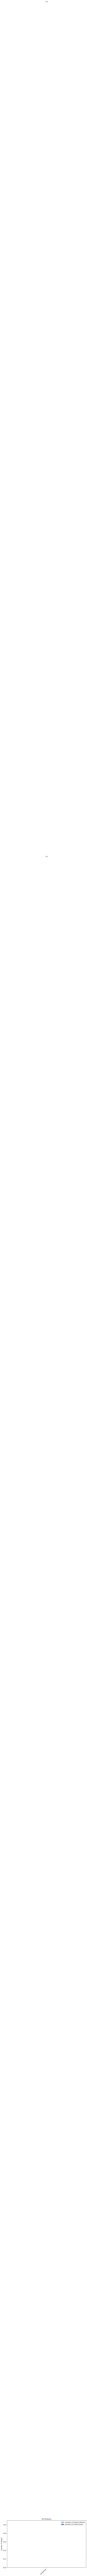

In [ ]:



scaffold_molecule_pd = scaffold_molecule_pd_repeats.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False)
plt.figure(figsize=(10,6))
color_list = sns.color_palette("deep", n_colors=10)
# Create a color mapping for each model name
model_names = sorted(scaffold_molecule_pd['ModelName'].tolist())
color_map = {name: color_list[i % len(color_list)] for i, name in enumerate(model_names)}

model_colors = [color_map[name] for name in scaffold_molecule_pd['ModelName']]
bars1 = plt.bar(scaffold_molecule_pd['ModelName'],scaffold_molecule_pd['Number_of_Finded_Scaffolds_mean'],label = 'Number of Finded Scaffolds',alpha = 0.6, color=model_colors )
bars2 = plt.bar(scaffold_molecule_pd['ModelName'],scaffold_molecule_pd['Number_of_Finded_Smiles_mean'],label = 'Number of Finded Smiles',alpha = 0.9,hatch="///", color=model_colors )

_ = plt.xticks(range(len(scaffold_molecule_pd['ModelName'])), scaffold_molecule_pd['ModelName'], rotation=45, ha='right')


for bar in bars1:
    
    
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height+3, f'{round(float(height),3)}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height+2, f'{round(float(height),3)}', ha='center', va='bottom')
    

plt.errorbar(scaffold_molecule_pd['ModelName'], scaffold_molecule_pd['Number_of_Finded_Scaffolds_mean'], 
             yerr=scaffold_molecule_pd['Number_of_Finded_Scaffolds_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

plt.errorbar(scaffold_molecule_pd['ModelName'], scaffold_molecule_pd['Number_of_Finded_Smiles_mean'], 
             yerr=scaffold_molecule_pd['Number_of_Finded_Smiles_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

    
    
plt.ylim(0, )  # Add 20% padding to the top
plt.ylabel('Number of Targets')
plt.title('All Proteins')
plt.legend()
plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/mol_scaffold_recovery_all_protein.svg',bbox_inches='tight',dpi=660,format='svg')
plt.show()

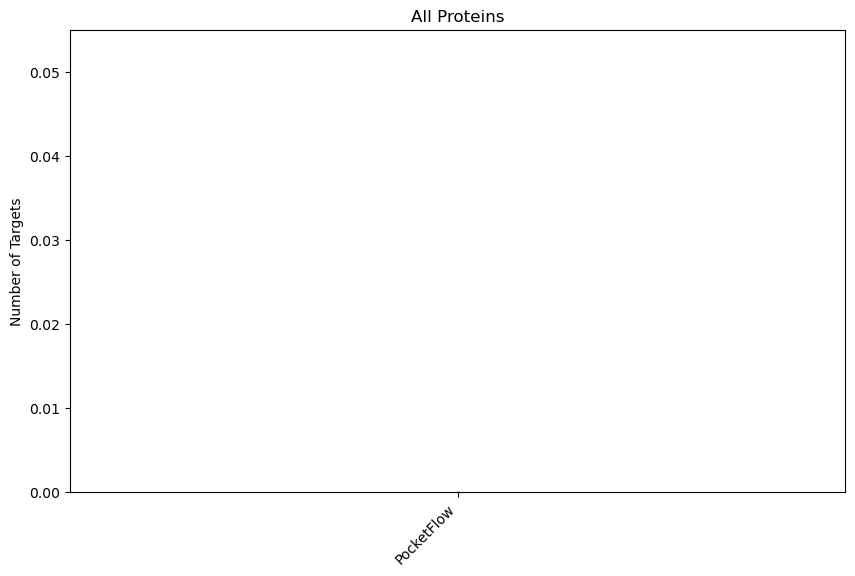

In [9]:
scaffold_molecule_pd = scaffold_molecule_pd_repeats.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False)
plt.figure(figsize=(10,6))
color_list = sns.color_palette("deep", n_colors=10)
model_names = sorted(scaffold_molecule_pd['ModelName'].tolist())
color_map = {name: color_list[i % len(color_list)] for i, name in enumerate(model_names)}
model_colors = [color_map[name] for name in scaffold_molecule_pd['ModelName']]

bars1 = plt.bar(scaffold_molecule_pd['ModelName'],scaffold_molecule_pd['Number_of_Finded_Scaffolds_mean'],label = 'Number of Finded Scaffolds',alpha = 0.6, color=model_colors)
bars2 = plt.bar(scaffold_molecule_pd['ModelName'],scaffold_molecule_pd['Number_of_Finded_Smiles_mean'],label = 'Number of Finded Smiles',alpha = 0.9,hatch="///", color=model_colors)

_ = plt.xticks(range(len(scaffold_molecule_pd['ModelName'])), scaffold_molecule_pd['ModelName'], rotation=45, ha='right')

plt.errorbar(scaffold_molecule_pd['ModelName'], scaffold_molecule_pd['Number_of_Finded_Scaffolds_mean'], 
             yerr=scaffold_molecule_pd['Number_of_Finded_Scaffolds_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

plt.errorbar(scaffold_molecule_pd['ModelName'], scaffold_molecule_pd['Number_of_Finded_Smiles_mean'], 
             yerr=scaffold_molecule_pd['Number_of_Finded_Smiles_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)
plt.ylim(0, )  # Add 20% padding to the top
plt.ylabel('Number of Targets')
plt.title('All Proteins')
# plt.legend()
plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/mol_scaffold_recovery_all_protein_no_text.svg',bbox_inches='tight',dpi=660,format='svg')
plt.show()

### UNseen Proteins


In [12]:
import json
with open('../../sup_info/UniprotIDs_duplicated_with_crossdock2020.json','r') as f:
    UniprotId_in_crossdock = json.load(f)


In [13]:
def getScaffoldAndSmilesSeen(all_result_path,UniprotId_in_crossdock,seen=True):
    all_results = os.listdir(all_result_path)
    all_results_pd = []

    for temp_path in all_results:
        model_name = os.path.splitext(temp_path)[0]
        temp_path = os.path.join(all_result_path, temp_path)
        temp_pd = pd.read_csv(temp_path)
        temp_pd['ModelName'] = [model_name]*len(temp_pd)
        
        # temp_pd['FindedScaffoldIsInTrainset'] = temp_pd.apply(lambda x :len(get_trainset_scaffold(x, crossdock2020_duplicated_uniprotId_map_smiles_in_trainset)), axis=1)
        # temp_pd['FindedSmilesIsInTrainset'] = temp_pd.apply(lambda x :len(get_trainset_smiles(x, crossdock2020_duplicated_uniprotId_map_smiles_in_trainset)), axis=1)
        all_results_pd.append(temp_pd)
    merged_result_pd = pd.concat(all_results_pd,axis = 0)#['ModelName'].value_counts()
    
    merged_result_pd['Dupliceted_UniprotID'] = merged_result_pd['UniprotID'].apply(lambda x: x in UniprotId_in_crossdock)
    if seen:
        merged_result_pd = merged_result_pd[merged_result_pd['Dupliceted_UniprotID']]
        print('Number of targets: ',len(merged_result_pd['UniprotID'].unique()))
    else:
        merged_result_pd = merged_result_pd[~merged_result_pd['Dupliceted_UniprotID']]
        print('Number of targets: ',len(merged_result_pd['UniprotID'].unique()))
    
    
    scaffold_molecule_pd = merged_result_pd.groupby('ModelName').agg(list)[['Finded_Smiles_Num','Finded_Scaffolds_Num']].reset_index()#.apply(lambda x: sum(x)/120,axis = 1).plot(kind = 'bar',figsize=(10,6))
    scaffold_molecule_pd['Mean_Finded_Scaffolds_Num'] = scaffold_molecule_pd['Finded_Scaffolds_Num'].apply(np.mean)
    scaffold_molecule_pd['Mean_Finded_Smiles_Num'] = scaffold_molecule_pd['Finded_Smiles_Num'].apply(np.mean)
    # 统计找到骨架和找到分子的靶点数目
    scaffold_molecule_pd['Number_of_Finded_Scaffolds'] = scaffold_molecule_pd['Finded_Scaffolds_Num'].apply(lambda x: np.sum(np.array(x, dtype=bool)))
    scaffold_molecule_pd['Number_of_Finded_Smiles'] = scaffold_molecule_pd['Finded_Smiles_Num'].apply(lambda x: np.sum(np.array(x, dtype=bool)))
    return scaffold_molecule_pd 

In [14]:

scaffold_molecule_pd1_seen = getScaffoldAndSmilesSeen(all_result_path1,UniprotId_in_crossdock,seen=True)
scaffold_molecule_pd2_seen = getScaffoldAndSmilesSeen(all_result_path2,UniprotId_in_crossdock,seen=True)
scaffold_molecule_pd3_seen = getScaffoldAndSmilesSeen(all_result_path3,UniprotId_in_crossdock,seen=True)
# scaffold_molecule_pd1_seen  = scaffold_molecule_pd1_seen [scaffold_molecule_pd1_seen ['ModelName'] != 'TamGen']
# scaffold_molecule_pd2_seen  = scaffold_molecule_pd2_seen [scaffold_molecule_pd2_seen ['ModelName'] != 'TamGen']
# scaffold_molecule_pd3_seen  = scaffold_molecule_pd3_seen [scaffold_molecule_pd3_seen ['ModelName'] != 'TamGen']

Number of targets:  1
Number of targets:  1
Number of targets:  1


In [15]:
scaffold_molecule_pd_repeats_seen = pd.concat([scaffold_molecule_pd1_seen,scaffold_molecule_pd2_seen,scaffold_molecule_pd3_seen],axis = 0)
scaffold_molecule_pd_repeats_seen = scaffold_molecule_pd_repeats_seen[['ModelName','Number_of_Finded_Scaffolds', 'Number_of_Finded_Smiles']].groupby('ModelName').agg(['mean','std']).reset_index()
scaffold_molecule_pd_repeats_seen.columns = ['ModelName','Number_of_Finded_Scaffolds_mean','Number_of_Finded_Scaffolds_std','Number_of_Finded_Smiles_mean','Number_of_Finded_Smiles_std']
scaffold_molecule_pd_repeats_seen.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False)

,ModelName,Number_of_Finded_Scaffolds_mean,Number_of_Finded_Scaffolds_std,Number_of_Finded_Smiles_mean,Number_of_Finded_Smiles_std
0,PocketFlow,0.0,0.0,0.0,0.0


In [16]:
scaffold_molecule_pd_repeats_seen.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False).to_csv('/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/mol_scaffold_recovery_seen_protein.csv',index = False)

In [19]:
import os
import pandas as pd

scaffold_molecule_pd_repeats_seen = pd.read_csv("/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/mol_scaffold_recovery_seen_protein.csv")

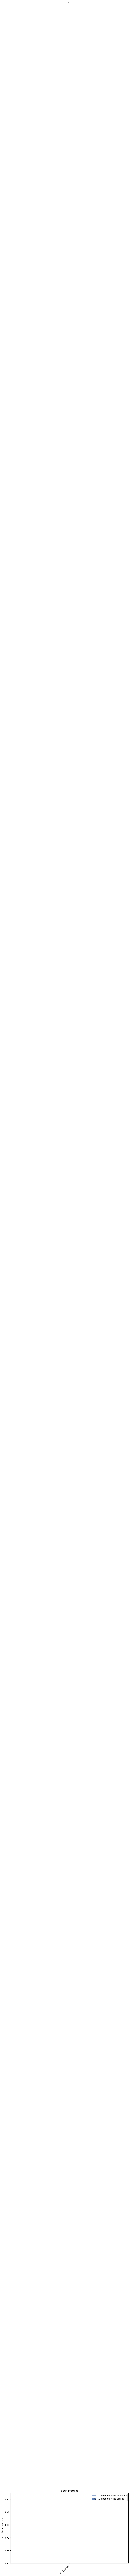

In [20]:

scaffold_molecule_pd_seen = scaffold_molecule_pd_repeats_seen.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False)
plt.figure(figsize=(10,6))

color_list = sns.color_palette("deep", n_colors=10)
model_names = sorted(scaffold_molecule_pd_seen['ModelName'].tolist())
color_map = {name: color_list[i % len(color_list)] for i, name in enumerate(model_names)}
model_colors = [color_map[name] for name in scaffold_molecule_pd_seen['ModelName']]

bars1 = plt.bar(scaffold_molecule_pd_seen['ModelName'],scaffold_molecule_pd_seen['Number_of_Finded_Scaffolds_mean'],label = 'Number of Finded Scaffolds',alpha = 0.6, color=model_colors)
bars2 = plt.bar(scaffold_molecule_pd_seen['ModelName'],scaffold_molecule_pd_seen['Number_of_Finded_Smiles_mean'],label = 'Number of Finded Smiles',alpha = 0.9,hatch="///", color=model_colors)


_ = plt.xticks(range(len(scaffold_molecule_pd_seen['ModelName'])), scaffold_molecule_pd_seen['ModelName'], rotation=45, ha='right')


for bar in bars1:
    
    
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height+2, f'{round(float(height),3)}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height+2, f'{round(float(height),3)}', ha='center', va='bottom')
    
# 绘制误差条
plt.errorbar(scaffold_molecule_pd_seen['ModelName'], scaffold_molecule_pd_seen['Number_of_Finded_Scaffolds_mean'], 
             yerr=scaffold_molecule_pd_seen['Number_of_Finded_Scaffolds_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

plt.errorbar(scaffold_molecule_pd_seen['ModelName'], scaffold_molecule_pd_seen['Number_of_Finded_Smiles_mean'], 
             yerr=scaffold_molecule_pd_seen['Number_of_Finded_Smiles_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

    
    
plt.ylim(0, )  # Add 20% padding to the top

plt.title('Seen Proteins')

plt.ylabel('Number of Targets')
plt.legend()

plt.show()

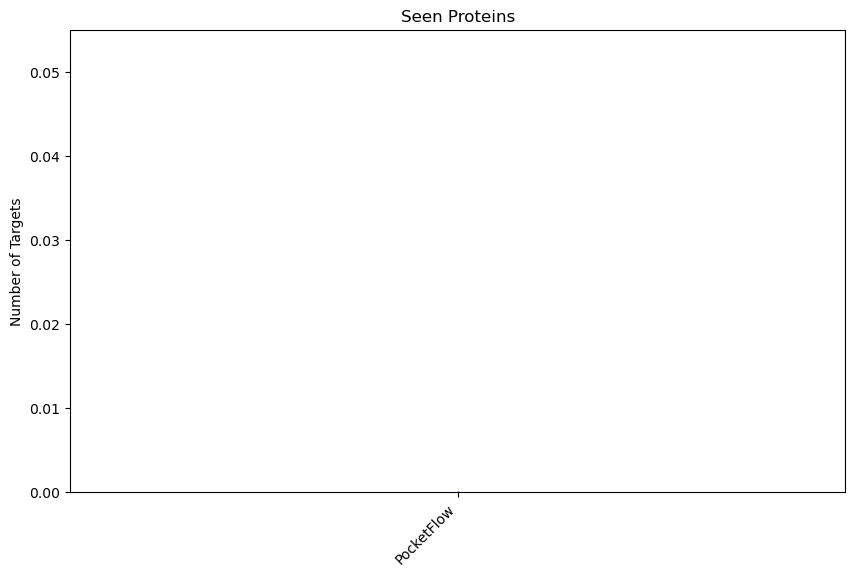

In [21]:

scaffold_molecule_pd_seen = scaffold_molecule_pd_repeats_seen.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False)
plt.figure(figsize=(10,6))
color_list = sns.color_palette("deep", n_colors=10)
model_names = sorted(scaffold_molecule_pd_seen['ModelName'].tolist())
color_map = {name: color_list[i % len(color_list)] for i, name in enumerate(model_names)}
model_colors = [color_map[name] for name in scaffold_molecule_pd_seen['ModelName']]

bars1 = plt.bar(scaffold_molecule_pd_seen['ModelName'],scaffold_molecule_pd_seen['Number_of_Finded_Scaffolds_mean'],label = 'Number of Finded Scaffolds',alpha = 0.6, color=model_colors)
bars2 = plt.bar(scaffold_molecule_pd_seen['ModelName'],scaffold_molecule_pd_seen['Number_of_Finded_Smiles_mean'],label = 'Number of Finded Smiles',alpha = 0.9,hatch="///", color=model_colors)
_ = plt.xticks(range(len(scaffold_molecule_pd_seen['ModelName'])), scaffold_molecule_pd_seen['ModelName'], rotation=45, ha='right')

# 绘制误差条
# 绘制误差条
plt.errorbar(scaffold_molecule_pd_seen['ModelName'], scaffold_molecule_pd_seen['Number_of_Finded_Scaffolds_mean'], 
             yerr=scaffold_molecule_pd_seen['Number_of_Finded_Scaffolds_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

plt.errorbar(scaffold_molecule_pd_seen['ModelName'], scaffold_molecule_pd_seen['Number_of_Finded_Smiles_mean'], 
             yerr=scaffold_molecule_pd_seen['Number_of_Finded_Smiles_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

    
plt.ylim(0, )  # Add 20% padding to the top
plt.title('Seen Proteins')
# plt.legend()
plt.ylabel('Number of Targets')
# plt.legend()
plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/mol_scaffold_recovery_seen_protein_no_text.svg',bbox_inches='tight',dpi=660,format='svg')
plt.show()

### unseen proteins

In [22]:

scaffold_molecule_pd1_unseen = getScaffoldAndSmilesSeen(all_result_path1,UniprotId_in_crossdock,seen=False)
scaffold_molecule_pd2_unseen = getScaffoldAndSmilesSeen(all_result_path2,UniprotId_in_crossdock,seen=False)
scaffold_molecule_pd3_unseen = getScaffoldAndSmilesSeen(all_result_path3,UniprotId_in_crossdock,seen=False)


Number of targets:  0
Number of targets:  0
Number of targets:  0


In [15]:
scaffold_molecule_pd_repeats_unseen = pd.concat([scaffold_molecule_pd1_unseen,scaffold_molecule_pd2_unseen,scaffold_molecule_pd3_unseen],axis = 0)
scaffold_molecule_pd_repeats_unseen = scaffold_molecule_pd_repeats_unseen[['ModelName','Number_of_Finded_Scaffolds', 'Number_of_Finded_Smiles']].groupby('ModelName').agg(['mean','std']).reset_index()
scaffold_molecule_pd_repeats_unseen.columns = ['ModelName','Number_of_Finded_Scaffolds_mean','Number_of_Finded_Scaffolds_std','Number_of_Finded_Smiles_mean','Number_of_Finded_Smiles_std']
scaffold_molecule_pd_repeats_unseen.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False)

,ModelName,Number_of_Finded_Scaffolds_mean,Number_of_Finded_Scaffolds_std,Number_of_Finded_Smiles_mean,Number_of_Finded_Smiles_std
9,diffSBDD_cond_moad,34.333333,0.577350,1.333333,0.57735
8,diffSBDD_cond_crossdocked,33.666667,0.577350,1.000000,0.00000
6,TamGen,33.333333,0.577350,4.666667,3.05505
4,PocketFlow,33.333333,0.577350,1.000000,0.00000
2,MolCraft,33.333333,1.527525,0.333333,0.57735
7,TargetDiff,32.000000,0.000000,0.000000,0.00000
1,FLAG,29.333333,0.577350,0.000000,0.00000
3,Pocket2Mol,28.666667,1.527525,0.000000,0.00000
0,DecompDiff,28.333333,0.577350,0.000000,0.00000
5,SurfGen,20.666667,1.527525,0.000000,0.00000


In [16]:
scaffold_molecule_pd_repeats_unseen.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False).to_csv('./withFixedSteroAndTautomer/results/success_targets/mol_scaffold_recovery_unseen_protein.csv',index = False)

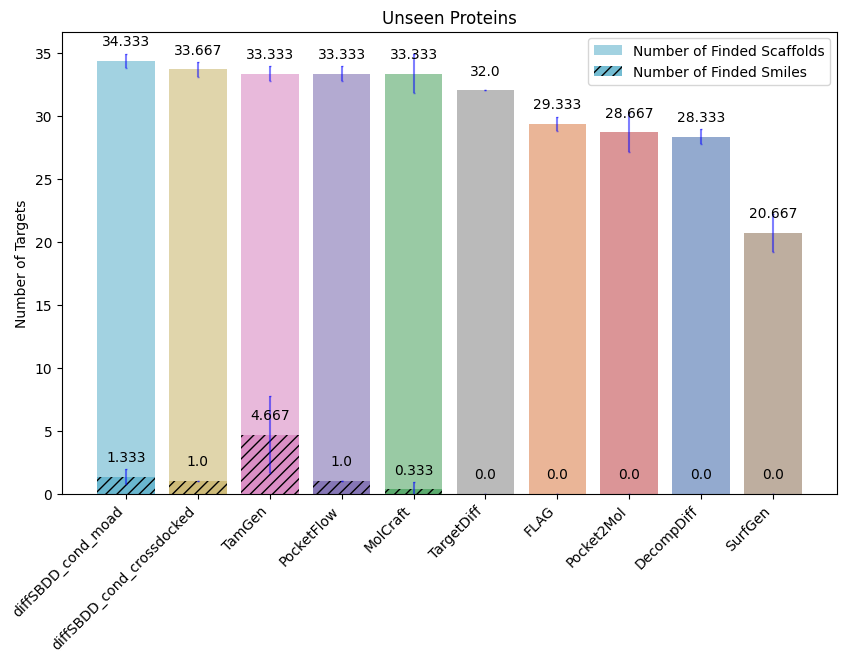

In [ ]:

scaffold_molecule_pd_unseen = scaffold_molecule_pd_repeats_unseen.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False)
plt.figure(figsize=(10,6))
color_list = sns.color_palette("deep", n_colors=10)
model_names = sorted(scaffold_molecule_pd_unseen['ModelName'].tolist())
color_map = {name: color_list[i % len(color_list)] for i, name in enumerate(model_names)}
model_colors = [color_map[name] for name in scaffold_molecule_pd_unseen['ModelName']]
bars1 = plt.bar(scaffold_molecule_pd_unseen['ModelName'],scaffold_molecule_pd_unseen['Number_of_Finded_Scaffolds_mean'],label = 'Number of Finded Scaffolds',alpha = 0.6, color=model_colors )
bars2 = plt.bar(scaffold_molecule_pd_unseen['ModelName'],scaffold_molecule_pd_unseen['Number_of_Finded_Smiles_mean'],label = 'Number of Finded Smiles',alpha = 0.9,hatch="///", color=model_colors )

_ = plt.xticks(range(len(scaffold_molecule_pd_unseen['ModelName'])), scaffold_molecule_pd_unseen['ModelName'], rotation=45, ha='right')


for bar in bars1:
    
    
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height+1, f'{round(float(height),3)}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height+1, f'{round(float(height),3)}', ha='center', va='bottom')
    
# 绘制误差条
plt.errorbar(scaffold_molecule_pd_unseen['ModelName'], scaffold_molecule_pd_unseen['Number_of_Finded_Scaffolds_mean'], 
             yerr=scaffold_molecule_pd_unseen['Number_of_Finded_Scaffolds_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

plt.errorbar(scaffold_molecule_pd_unseen['ModelName'], scaffold_molecule_pd_unseen['Number_of_Finded_Smiles_mean'], 
             yerr=scaffold_molecule_pd_unseen['Number_of_Finded_Smiles_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

    
    
plt.ylim(0, )  # Add 20% padding to the top

plt.title('Unseen Proteins')

plt.ylabel('Number of Targets')
plt.legend()
plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/mol_scaffold_recovery_unseen_protein.svg',bbox_inches='tight',dpi=660,format='svg')
plt.show()

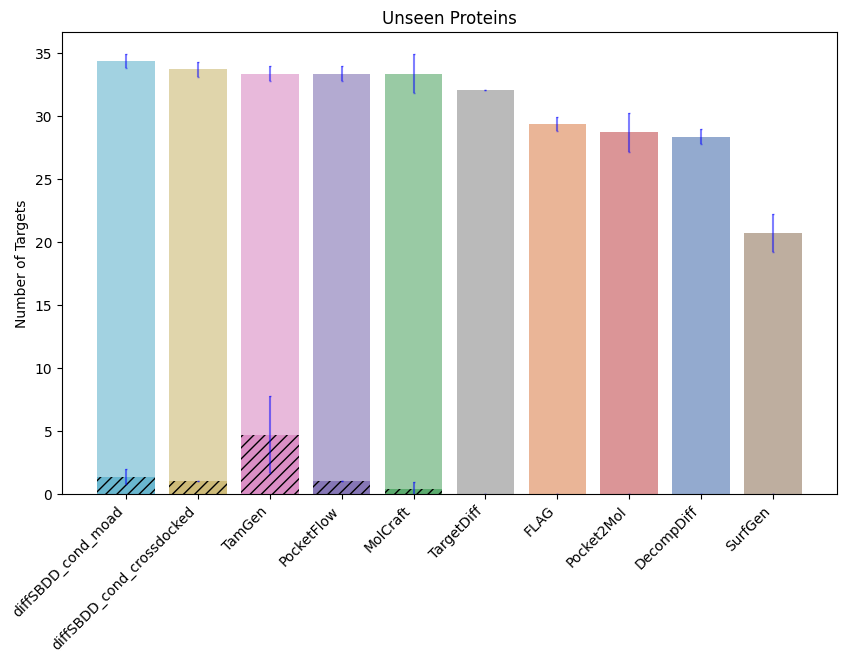

In [ ]:

scaffold_molecule_pd_unseen = scaffold_molecule_pd_repeats_unseen.sort_values(by = 'Number_of_Finded_Scaffolds_mean',ascending = False)
plt.figure(figsize=(10,6))
color_list = sns.color_palette("deep", n_colors=10)
model_names = sorted(scaffold_molecule_pd_unseen['ModelName'].tolist())
color_map = {name: color_list[i % len(color_list)] for i, name in enumerate(model_names)}
model_colors = [color_map[name] for name in scaffold_molecule_pd_unseen['ModelName']]
bars1 = plt.bar(scaffold_molecule_pd_unseen['ModelName'],scaffold_molecule_pd_unseen['Number_of_Finded_Scaffolds_mean'],label = 'Number of Finded Scaffolds',alpha = 0.6, color=model_colors )
bars2 = plt.bar(scaffold_molecule_pd_unseen['ModelName'],scaffold_molecule_pd_unseen['Number_of_Finded_Smiles_mean'],label = 'Number of Finded Smiles',alpha = 0.9,hatch="///", color=model_colors )

_ = plt.xticks(range(len(scaffold_molecule_pd_unseen['ModelName'])), scaffold_molecule_pd_unseen['ModelName'], rotation=45, ha='right')

    

plt.errorbar(scaffold_molecule_pd_unseen['ModelName'], scaffold_molecule_pd_unseen['Number_of_Finded_Scaffolds_mean'], 
             yerr=scaffold_molecule_pd_unseen['Number_of_Finded_Scaffolds_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

plt.errorbar(scaffold_molecule_pd_unseen['ModelName'], scaffold_molecule_pd_unseen['Number_of_Finded_Smiles_mean'], 
             yerr=scaffold_molecule_pd_unseen['Number_of_Finded_Smiles_std'], fmt='none', color='blue', capsize=1,alpha = 0.5)

    
    
plt.ylim(0, )  # Add 20% padding to the top
# plt.ylabel('Number of Targets')
plt.title('Unseen Proteins')

plt.ylabel('Number of Targets')

plt.savefig('/home/data-house-01/cdhofficial/MolGens/TestSample_Denovo/Round1/De_novo_Results/mol_scaffold_recovery_unseen_protein_no_text.svg',bbox_inches='tight',dpi=660,format='svg')
plt.show()